# Bids vs Stock vs Both

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns

In [2]:
bid_thirty=pd.read_csv('bid_thirty.csv')
stock_thirty=pd.read_csv('stock_thirty.csv')

In [3]:
bids=bid_thirty.buyer.unique()
buys=stock_thirty.buyer.unique()

In [4]:
gmv_stock_thirty=pd.DataFrame(stock_thirty.groupby('buyer')['price'].sum().sort_values(ascending=False))
gmv_stock_thirty.head()

,price
buyer,
everything but the house,249278
hk estate jewels,162341
the realreal,158074
rue gilt,118869
harley 2019,106335


In [5]:
win_thirty=bid_thirty.loc[bid_thirty['bid']>=bid_thirty['winning_price']]

In [6]:
gmv_bid_thirty=pd.DataFrame(win_thirty.groupby('buyer')['winning_price'].sum().sort_values(ascending=False))
gmv_bid_thirty.head()

,winning_price
buyer,
rue gilt,524614.0
harley 2019,173926.0
bagriculture,109729.0
season 2 consign,27858.0
bag borrow steal,17915.0


In [7]:
gmv=pd.merge(gmv_stock_thirty, gmv_bid_thirty, left_index=True, right_index=True, how='outer')

In [8]:
gmv.shape

(90, 2)

In [9]:
gmv=gmv.fillna(0)

In [10]:
gmv['total_gmv']=gmv['price']+gmv['winning_price']

In [11]:
gmv.head()

,price,winning_price,total_gmv
buyer,,,
adore the couture,0.0,217.0,217.0
agents in style,647.0,0.0,647.0
alexis suitcase,13288.0,0.0,13288.0
artex,0.0,190.0,190.0
atelier curated,2673.0,0.0,2673.0


In [12]:
gmv=gmv.rename(columns={'price':'stock_gmv', 'winning_price':'auction_gmv'})

In [13]:
gmv=gmv.sort_values(by='total_gmv', ascending=False)
gmv.head()

,stock_gmv,auction_gmv,total_gmv
buyer,,,
rue gilt,118869.0,524614.0,643483.0
harley 2019,106335.0,173926.0,280261.0
everything but the house,249278.0,0.0,249278.0
hk estate jewels,162341.0,0.0,162341.0
the realreal,158074.0,0.0,158074.0


In [14]:
gmv['bid']=gmv['auction_gmv'].apply(lambda x:'Y' if x>0 else 'N')
gmv['stock']=gmv['stock_gmv'].apply(lambda x:'Y' if x>0 else 'N')

gmv.head()

,stock_gmv,auction_gmv,total_gmv,bid,stock
buyer,,,,,
rue gilt,118869.0,524614.0,643483.0,Y,Y
harley 2019,106335.0,173926.0,280261.0,Y,Y
everything but the house,249278.0,0.0,249278.0,N,Y
hk estate jewels,162341.0,0.0,162341.0,N,Y
the realreal,158074.0,0.0,158074.0,N,Y


In [15]:
# gmv.to_excel('thirty_day_gmv.xlsx')

## YTD

In [16]:
bid=pd.read_csv('bid_ytd.csv')
stock=pd.read_csv('stock_ytd.csv')

In [17]:
stock['submitted_on']=pd.to_datetime(stock['submitted_on'])
bid['bid_placed_on']=pd.to_datetime(bid['bid_placed_on'])

In [18]:
gmv_stock=pd.DataFrame(stock.groupby('buyer')['price'].sum().sort_values(ascending=False))

win=bid.loc[bid['bid']>=bid['winning_price']]
gmv_bid=pd.DataFrame(win.groupby('buyer')['winning_price'].sum().sort_values(ascending=False))

In [19]:
gmv_ytd=pd.merge(gmv_stock, gmv_bid, left_index=True, right_index=True, how='outer')
gmv_ytd=gmv_ytd.fillna(0)
gmv_ytd['total_gmv']=gmv_ytd['price']+gmv_ytd['winning_price']
gmv_ytd=gmv_ytd.rename(columns={'price':'stock_gmv', 'winning_price':'auction_gmv'})
gmv_ytd=gmv_ytd.sort_values(by='total_gmv', ascending=False)
gmv_ytd.head()

,stock_gmv,auction_gmv,total_gmv
buyer,,,
rue gilt,425588.00,2118552.0,2544140.00
the realreal,1350271.64,41218.0,1391489.64
harley 2019,413419.05,517353.0,930772.05
everything but the house,719151.35,3380.0,722531.35
sotheby's,452611.97,122819.0,575430.97


In [20]:
last_bid=pd.DataFrame(bid.groupby('buyer')['date'].last().rename('last_bid').sort_values(ascending=False))
last_stock=pd.DataFrame(stock.groupby('buyer')['date'].last().rename('last_stock').sort_values(ascending=False))

In [21]:
gmv_ytd=pd.merge(gmv_ytd, last_bid, left_index=True, right_index=True, how='outer')
gmv_ytd=pd.merge(gmv_ytd, last_stock, left_index=True, right_index=True, how='outer')

gmv_ytd.sort_values(by='total_gmv').head()

,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock
buyer,,,,,
fete,0.0,47.0,47.0,3/12/21,NaN
beausoleil boutique,0.0,65.0,65.0,3/12/21,NaN
the unique store,139.0,0.0,139.0,1/29/21,1/5/21
nu2ucf,163.0,0.0,163.0,NaN,1/28/21
bougie booth,179.0,0.0,179.0,4/6/21,3/10/21


In [22]:
gmv_ytd['last_bid']=pd.to_datetime(gmv_ytd['last_bid'])
gmv_ytd['last_stock']=pd.to_datetime(gmv_ytd['last_stock'])

In [23]:
bid_startA='04-09-2021'
bid_end='05-11-2021'

bid_thirty_mask=(gmv_ytd['last_bid'] > bid_startA) & (gmv_ytd['last_bid'] <= bid_end)
gmv_ytd['bid_last_30']='N'
gmv_ytd.loc[bid_thirty_mask,'bid_last_30']='Y'

stock_thirty_mask=(gmv_ytd['last_stock'] > bid_startA) & (gmv_ytd['last_stock'] <= bid_end)
gmv_ytd['stock_last_30']='N'
gmv_ytd.loc[stock_thirty_mask,'stock_last_30']='Y'

bid_startB='03-11-2021'

bid_sixty_mask = (gmv_ytd['last_bid'] > bid_startB) & (gmv_ytd['last_bid'] <= bid_end)
gmv_ytd['bid_last_60']='N'
gmv_ytd.loc[bid_sixty_mask, 'bid_last_60']='Y'

stock_sixty_mask = (gmv_ytd['last_stock'] > bid_startB) & (gmv_ytd['last_stock'] <= bid_end)
gmv_ytd['stock_last_60']='N'
gmv_ytd.loc[stock_sixty_mask, 'stock_last_60']='Y'

bid_startC='02-11-2021'

bid_ninety_mask = (gmv_ytd['last_bid'] > bid_startC) & (gmv_ytd['last_bid'] <= bid_end)
gmv_ytd['bid_last_90']='N'
gmv_ytd.loc[bid_ninety_mask, 'bid_last_90']='Y'

stock_ninety_mask = (gmv_ytd['last_stock'] > bid_startC) & (gmv_ytd['last_stock'] <= bid_end)
gmv_ytd['stock_last_90']='N'
gmv_ytd.loc[stock_ninety_mask, 'stock_last_90']='Y'

gmv_ytd.head()

,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,bid_last_30,stock_last_30,bid_last_60,stock_last_60,bid_last_90,stock_last_90
buyer,,,,,,,,,,,
adore the couture,994.0,10396.0,11390.0,2021-04-11,2021-04-05,Y,N,Y,Y,Y,Y
agents in style,794.0,0.0,794.0,2021-03-28,2021-04-24,N,Y,Y,Y,Y,Y
agora vintage,1539.0,0.0,1539.0,NaT,2021-01-25,N,N,N,N,N,N
alexis suitcase,13288.0,0.0,13288.0,NaT,2021-05-02,N,Y,N,Y,N,Y
ambiance,22653.0,10376.0,33029.0,2021-06-04,2021-02-01,N,N,N,N,N,N


In [24]:
# gmv_ytd.to_excel('gmv_ytd.xlsx')

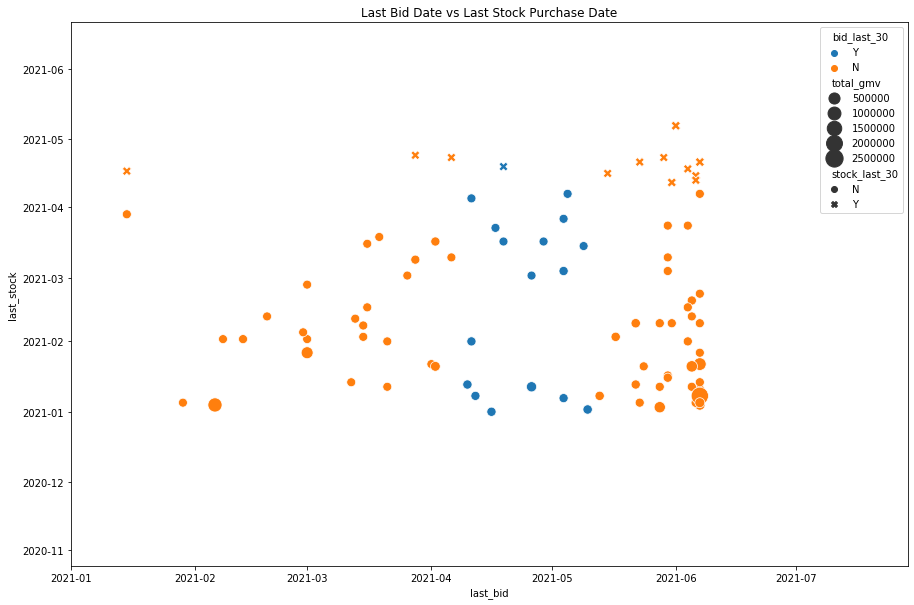

In [25]:
plt.figure(figsize=(15,10))
ax=sns.scatterplot(x='last_bid', y='last_stock', data=gmv_ytd, hue='bid_last_30',
                style='stock_last_30', size='total_gmv', sizes=(80,300))
ax.set_xlim(gmv_ytd['last_stock'].min())
plt.title('Last Bid Date vs Last Stock Purchase Date')
plt.show()

In [26]:
bs_df=gmv_ytd.loc[(gmv_ytd['bid_last_30']=='Y') & (gmv_ytd['stock_last_30']=='Y')]
bs_df.head()

,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,bid_last_30,stock_last_30,bid_last_60,stock_last_60,bid_last_90,stock_last_90
buyer,,,,,,,,,,,
n'used fashions,8029.0,0.0,8029.0,2021-04-19,2021-04-19,Y,Y,Y,Y,Y,Y


## 2020 and 2021

In [27]:
all_stock=pd.read_csv('all_stock.csv')
all_bid=pd.read_csv('all_bid.csv')

/Users/sydneybednar/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
# date time columns
all_stock['submitted_date']=pd.to_datetime(all_stock['submitted_date'])
all_stock['date']=all_stock['submitted_date'].dt.date

all_bid['bid_placed_on']=pd.to_datetime(all_bid['bid_placed_on'])
all_bid['date']=all_bid['bid_placed_on'].dt.date

In [29]:
# sort values by date
all_stock=all_stock.sort_values(by='submitted_date')
all_bid=all_bid.sort_values(by='bid_placed_on')

In [30]:
# groupby buyer stock
all_gmv_stock=pd.DataFrame(all_stock.groupby('buyer')['price'].sum().sort_values(ascending=False))

# groupby buyer bids
all_win=all_bid.loc[all_bid['bid']>=all_bid['winning_price']]
all_gmv_bid=pd.DataFrame(all_win.groupby('buyer')['winning_price'].sum().sort_values(ascending=False))

In [31]:
all_last_bid=pd.DataFrame(all_bid.groupby('buyer')['date'].last().rename('last_bid').sort_values(ascending=False))
all_last_stock=pd.DataFrame(all_stock.groupby('buyer')['date'].last().rename('last_stock').sort_values(ascending=False))

In [32]:
gmv_two=pd.merge(all_gmv_stock, all_gmv_bid, left_index=True, right_index=True, how='outer')
gmv_two=gmv_two.fillna(0)
gmv_two['total_gmv']=gmv_two['price']+gmv_two['winning_price']
gmv_two=gmv_two.rename(columns={'price':'stock_gmv', 'winning_price':'auction_gmv'})
gmv_two=gmv_two.sort_values(by='total_gmv', ascending=False)


gmv_two=pd.merge(gmv_two, all_last_bid, left_index=True, right_index=True, how='outer')
gmv_two=pd.merge(gmv_two, all_last_stock, left_index=True, right_index=True, how='outer')
gmv_two['last_win']=all_win.groupby('buyer')['date'].last().rename('last_win').sort_values(ascending=False)

gmv_two=gmv_two.sort_values(by='total_gmv', ascending=False)

gmv_two.head()

,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,last_win
buyer,,,,,,
rue gilt,758819.10,3015213.0,3774032.10,2021-06-07,2021-05-11,2021-06-07
the realreal,2034427.29,230365.0,2264792.29,2021-02-06,2021-06-08,2021-01-19
harley 2019,759469.30,735759.0,1495228.30,2021-06-07,2021-06-09,2021-06-07
marque luxury,16984.00,1033820.0,1050804.00,2021-05-30,2020-07-21,2021-05-30
bagriculture,0.00,907040.0,907040.00,2021-06-06,NaN,2021-06-06


In [33]:
import datetime

startA=datetime.datetime(2021,3,11)

stock_ninety_mask=(gmv_two['last_stock'] > startA.date())
gmv_two['stock_last_90']='N'
gmv_two.loc[stock_ninety_mask,'stock_last_90']='Y'

bid_ninety_mask=(gmv_two['last_bid'] > startA.date())
gmv_two['bid_last_90']='N'
gmv_two.loc[bid_ninety_mask,'bid_last_90']='Y'

gmv_two.head()

,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,last_win,stock_last_90,bid_last_90
buyer,,,,,,,,
rue gilt,758819.10,3015213.0,3774032.10,2021-06-07,2021-05-11,2021-06-07,Y,Y
the realreal,2034427.29,230365.0,2264792.29,2021-02-06,2021-06-08,2021-01-19,Y,N
harley 2019,759469.30,735759.0,1495228.30,2021-06-07,2021-06-09,2021-06-07,Y,Y
marque luxury,16984.00,1033820.0,1050804.00,2021-05-30,2020-07-21,2021-05-30,N,Y
bagriculture,0.00,907040.0,907040.00,2021-06-06,NaN,2021-06-06,N,Y


In [34]:
gmv_two['total_wins']=all_win.groupby('buyer')['bid'].count()
gmv_two['total_bids']=all_bid.groupby('buyer')['bid'].count()
gmv_two['win_rate']=100*gmv_two['total_wins']/gmv_two['total_bids']


gmv_two.head()

,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,last_win,stock_last_90,bid_last_90,total_wins,total_bids,win_rate
buyer,,,,,,,,,,,
rue gilt,758819.10,3015213.0,3774032.10,2021-06-07,2021-05-11,2021-06-07,Y,Y,5010.0,12533.0,39.974467
the realreal,2034427.29,230365.0,2264792.29,2021-02-06,2021-06-08,2021-01-19,Y,N,64.0,286.0,22.377622
harley 2019,759469.30,735759.0,1495228.30,2021-06-07,2021-06-09,2021-06-07,Y,Y,467.0,2352.0,19.855442
marque luxury,16984.00,1033820.0,1050804.00,2021-05-30,2020-07-21,2021-05-30,N,Y,2022.0,6882.0,29.380994
bagriculture,0.00,907040.0,907040.00,2021-06-06,NaN,2021-06-06,N,Y,1893.0,23889.0,7.924149


In [35]:
gmv_two=gmv_two.reset_index()
gmv_two['wins_on_multi_bid']=0

In [36]:
multi_bid=pd.DataFrame(all_bid.groupby('item_id')['bid'].count().sort_values(ascending=False)).reset_index()
multi_bid=multi_bid.loc[multi_bid['bid']>1]
multi_bid

,item_id,bid
0,2416951,21
1,2278090,16
2,1808793,15
3,2019470,15
4,2094577,14
...,...,...
14607,2701363,2
14608,2173328,2
14609,2626728,2
14610,2723082,2


In [37]:
for item in multi_bid['item_id']:
        sub=all_bid[all_bid['item_id']==item]
        winner=sub.loc[sub['bid']>=sub['winning_price']]['buyer']
        gmv_two.loc[gmv_two['buyer'].isin(list(winner)), 'wins_on_multi_bid']+=1

gmv_two.head()

,buyer,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,last_win,stock_last_90,bid_last_90,total_wins,total_bids,win_rate,wins_on_multi_bid
0,rue gilt,758819.10,3015213.0,3774032.10,2021-06-07,2021-05-11,2021-06-07,Y,Y,5010.0,12533.0,39.974467,1449
1,the realreal,2034427.29,230365.0,2264792.29,2021-02-06,2021-06-08,2021-01-19,Y,N,64.0,286.0,22.377622,14
2,harley 2019,759469.30,735759.0,1495228.30,2021-06-07,2021-06-09,2021-06-07,Y,Y,467.0,2352.0,19.855442,142
3,marque luxury,16984.00,1033820.0,1050804.00,2021-05-30,2020-07-21,2021-05-30,N,Y,2022.0,6882.0,29.380994,354
4,bagriculture,0.00,907040.0,907040.00,2021-06-06,NaN,2021-06-06,N,Y,1893.0,23889.0,7.924149,184


In [38]:
losers=all_bid[all_bid['bid']<all_bid['winning_price']]
losers['within_10_percent']='N'

losers.loc[(losers['bid']>=losers['winning_price']*0.9),'within_10_percent']='Y'

lost=(losers.loc[losers['within_10_percent']=='Y']
 .groupby('buyer')
 .count()['bid']
 .sort_values(ascending=False)
 .rename('bids_within_10_percent')
 .reset_index())

gmv_two=gmv_two.merge(lost, how='outer')

gmv_two['bids_within_10_percent'].fillna(0)
gmv_two.head()

/Users/sydneybednar/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sydneybednar/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,buyer,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,last_win,stock_last_90,bid_last_90,total_wins,total_bids,win_rate,wins_on_multi_bid,bids_within_10_percent
0,rue gilt,758819.10,3015213.0,3774032.10,2021-06-07,2021-05-11,2021-06-07,Y,Y,5010.0,12533.0,39.974467,1449,2970.0
1,the realreal,2034427.29,230365.0,2264792.29,2021-02-06,2021-06-08,2021-01-19,Y,N,64.0,286.0,22.377622,14,69.0
2,harley 2019,759469.30,735759.0,1495228.30,2021-06-07,2021-06-09,2021-06-07,Y,Y,467.0,2352.0,19.855442,142,669.0
3,marque luxury,16984.00,1033820.0,1050804.00,2021-05-30,2020-07-21,2021-05-30,N,Y,2022.0,6882.0,29.380994,354,1596.0
4,bagriculture,0.00,907040.0,907040.00,2021-06-06,NaN,2021-06-06,N,Y,1893.0,23889.0,7.924149,184,3039.0


In [39]:
gmv_two[['total_wins','total_bids', 'bids_within_10_percent']]=(gmv_two[['total_wins','total_bids','bids_within_10_percent']]
                                                                .fillna(0))

gmv_two.head()

,buyer,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,last_win,stock_last_90,bid_last_90,total_wins,total_bids,win_rate,wins_on_multi_bid,bids_within_10_percent
0,rue gilt,758819.10,3015213.0,3774032.10,2021-06-07,2021-05-11,2021-06-07,Y,Y,5010.0,12533.0,39.974467,1449,2970.0
1,the realreal,2034427.29,230365.0,2264792.29,2021-02-06,2021-06-08,2021-01-19,Y,N,64.0,286.0,22.377622,14,69.0
2,harley 2019,759469.30,735759.0,1495228.30,2021-06-07,2021-06-09,2021-06-07,Y,Y,467.0,2352.0,19.855442,142,669.0
3,marque luxury,16984.00,1033820.0,1050804.00,2021-05-30,2020-07-21,2021-05-30,N,Y,2022.0,6882.0,29.380994,354,1596.0
4,bagriculture,0.00,907040.0,907040.00,2021-06-06,NaN,2021-06-06,N,Y,1893.0,23889.0,7.924149,184,3039.0


In [40]:
gmv_two[gmv_two['buyer']=='store5a']

,buyer,stock_gmv,auction_gmv,total_gmv,last_bid,last_stock,last_win,stock_last_90,bid_last_90,total_wins,total_bids,win_rate,wins_on_multi_bid,bids_within_10_percent
26,store5a,70082.75,754.0,70836.75,2020-08-08,2021-05-20,2020-08-08,Y,N,1.0,6.0,16.666667,1,3.0


In [41]:
# gmv_two[(gmv_two['bid_last_90']=='N') & (gmv_two['stock_last_90']=='N')]

In [42]:
gmv_two.to_excel('gmv_2020_2021.xlsx')

## Wholesale HP Data

In [43]:
stock_category=(pd.DataFrame(all_stock.groupby('category_name')['price']
                       .sum()
                       .rename('stock_gmv')
                       .sort_values(ascending=False)))

stock_category['items_sold']=all_stock.groupby('category_name')['price'].count()

In [44]:
auc_category=(pd.DataFrame(all_win.groupby('category_name')['winning_price']
                       .sum()
                       .rename('auction_gmv')
                       .sort_values(ascending=False)))

auc_category['items_won']=all_win.groupby('category_name')['winning_price'].count()

auc_category

,auction_gmv,items_won
category_name,,
Shoulder Bags,2689553.0,3140
Totes,1660926.0,2133
Travel,637398.0,971
Handbags,436729.0,364
Top Handles & Satchels,432702.0,713
Wallets,352189.0,946
Necklaces,296871.0,618
Crossbody Bags,281922.0,419
Scarves/Wraps,249143.0,1078


In [45]:
category=auc_category.merge(stock_category, left_index=True, right_index=True, how='outer')

category=category.fillna(0)
category['total_gmv']=category['stock_gmv']+category['auction_gmv']
category['total_items_sold']=category['items_sold']+category['items_won']

category=category.sort_values(by='total_gmv', ascending=False)
cols=['auction_gmv', 'stock_gmv', 'total_gmv','items_sold','items_won', 'total_items_sold']
category=category[cols]
category.sort_values(by='total_items_sold', ascending=False)

,auction_gmv,stock_gmv,total_gmv,items_sold,items_won,total_items_sold
category_name,,,,,,
Shoulder Bags,2689553.0,3832729.65,6522282.65,4051.0,3140.0,7191.0
Totes,1660926.0,1173155.41,2834081.41,1320.0,2133.0,3453.0
Wallets,352189.0,327442.80,679631.80,1048.0,946.0,1994.0
Scarves/Wraps,249143.0,171871.56,421014.56,737.0,1078.0,1815.0
Top Handles & Satchels,432702.0,1452851.65,1885553.65,1049.0,713.0,1762.0
Travel,637398.0,294484.70,931882.70,539.0,971.0,1510.0
Clutches,247611.0,287113.87,534724.87,796.0,564.0,1360.0
Handbags,436729.0,321540.48,758269.48,588.0,364.0,952.0
Crossbody Bags,281922.0,284477.05,566399.05,468.0,419.0,887.0


In [46]:
# category.to_excel('stockauc_categories.xlsx')

In [47]:
all_stock.loc[all_stock['brand_name']=='Saint Laurent', 'brand_name']='Yves Saint Laurent'

In [48]:
stock_brand=(pd.DataFrame(all_stock.groupby('brand_name')['price']
                       .sum()
                       .rename('stock_gmv')
                       .sort_values(ascending=False)))

stock_brand['items_sold']=all_stock.groupby('brand_name')['price'].count()

stock_brand.head()

,stock_gmv,items_sold
brand_name,,
Louis Vuitton,3016947.25,5586
Chanel,1933242.98,1276
Hermès,1896248.96,1152
Gucci,785133.25,1859
Christian Dior,224228.07,254


In [49]:
all_win.loc[all_win['brand_name']=='Saint Laurent', 'brand_name']='Yves Saint Laurent'

/Users/sydneybednar/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
bid_brand=(pd.DataFrame(all_win.groupby('brand_name')['winning_price']
                       .sum()
                       .rename('auction_gmv')
                       .sort_values(ascending=False)))

bid_brand['items_won']=all_win.groupby('brand_name')['winning_price'].count()

bid_brand.head()

,auction_gmv,items_won
brand_name,,
Louis Vuitton,4010001.0,6485
Chanel,2001806.0,2520
Hermès,824095.0,1543
Gucci,605725.0,1209
Christian Dior,151926.0,264


In [51]:
brand=stock_brand.merge(bid_brand, left_index=True, right_index=True, how='outer')

brand=brand.fillna(0)
brand['total_gmv']=brand['stock_gmv']+brand['auction_gmv']
brand['total_items_sold']=brand['items_sold']+brand['items_won']

brand=brand.sort_values(by='total_gmv', ascending=False)
cols=['auction_gmv', 'stock_gmv', 'total_gmv','items_sold','items_won', 'total_items_sold']
brand=brand[cols]
brand=brand.sort_values(by='total_items_sold', ascending=False)

In [52]:
# brand.to_excel('stockauc_brands.xlsx')